# Reading the Stock Data

The 3 Stocks of different Industries are as follows:- 
1) Tesla
2) Bitcoin
3) Reliance

## 1.Tesla

In [145]:
# lets use the library!!

In [316]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader as web
import datetime
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2019, 1, 30)
tesla = web.DataReader('TSLA' , 'yahoo', start, end)
tesla.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,231.380005,219.000000,230.720001,223.410004,6827100,223.410004
2016-01-05,226.889999,220.000000,226.360001,223.429993,3186800,223.429993
2016-01-06,220.050003,215.979996,220.000000,219.039993,3779100,219.039993
2016-01-07,218.440002,213.669998,214.190002,215.649994,3554300,215.649994
2016-01-08,220.440002,210.770004,217.860001,211.000000,3628100,211.000000
2016-01-11,214.449997,203.000000,214.009995,207.850006,4091400,207.850006
2016-01-12,213.740005,205.309998,211.600006,209.970001,3091900,209.970001
2016-01-13,212.649994,200.000000,212.009995,200.309998,4126400,200.309998
2016-01-14,210.000000,193.380005,202.210007,206.179993,6490700,206.179993


save a dataset file in csv

In [317]:
tesla.to_csv('tesla.csv')

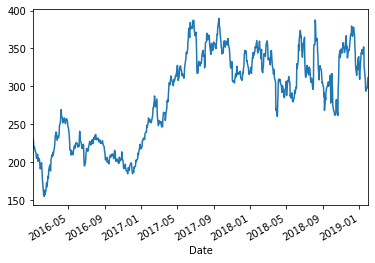

In [318]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = tesla['High']
vol.plot()

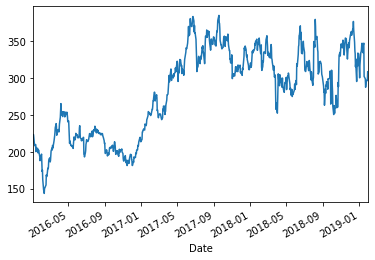

In [319]:
close = tesla['Close']
close.plot()

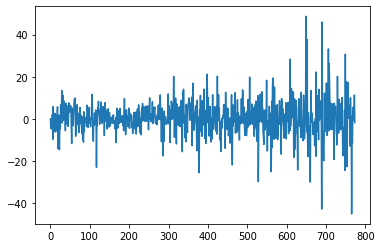

In [320]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

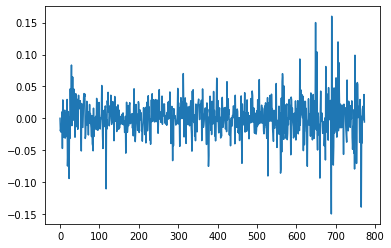

In [321]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [322]:
vol.corr(close)
# a value of 0.3 essentially means little correlation..

0.9972553834914243

# Moving Average

the moving average can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends.

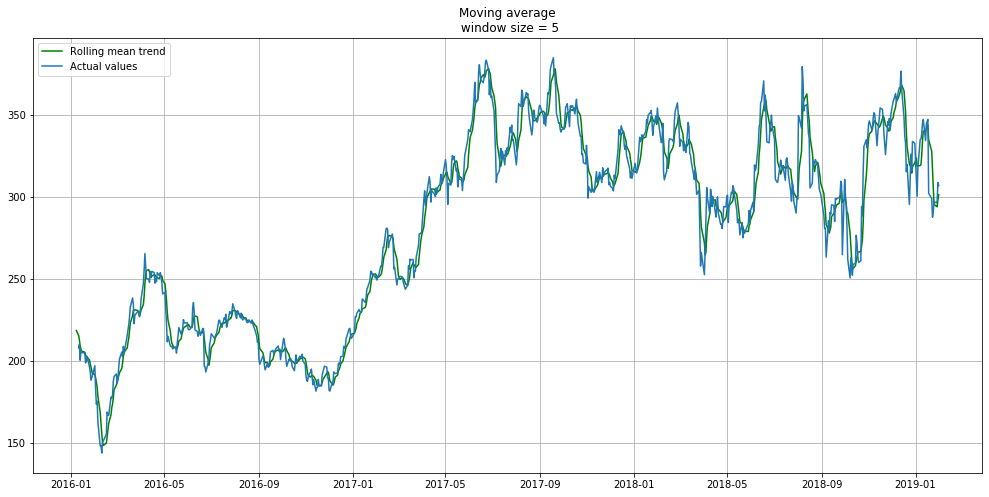

In [323]:
from sklearn.metrics import mean_absolute_error

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(tesla.Close, 5)


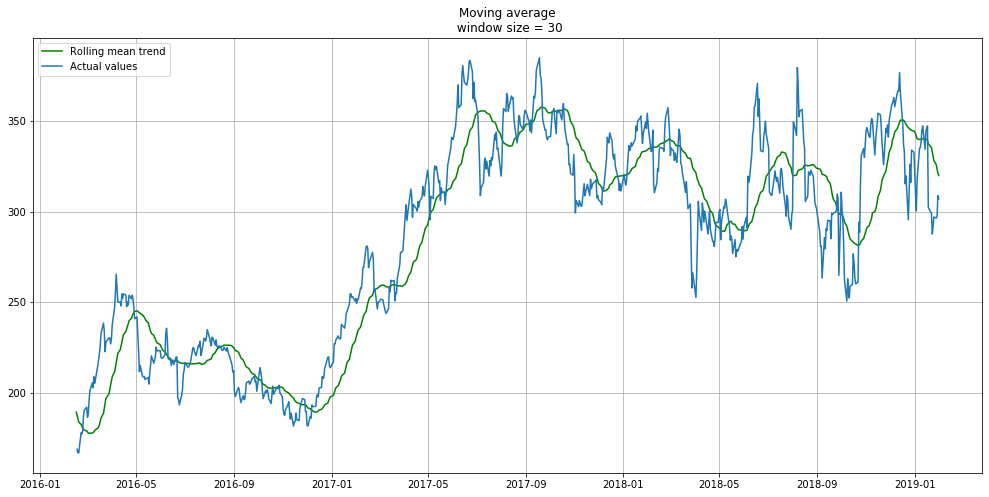

In [324]:
#Smooth by the previous month (30 days)
plot_moving_average(tesla.Close, 30)


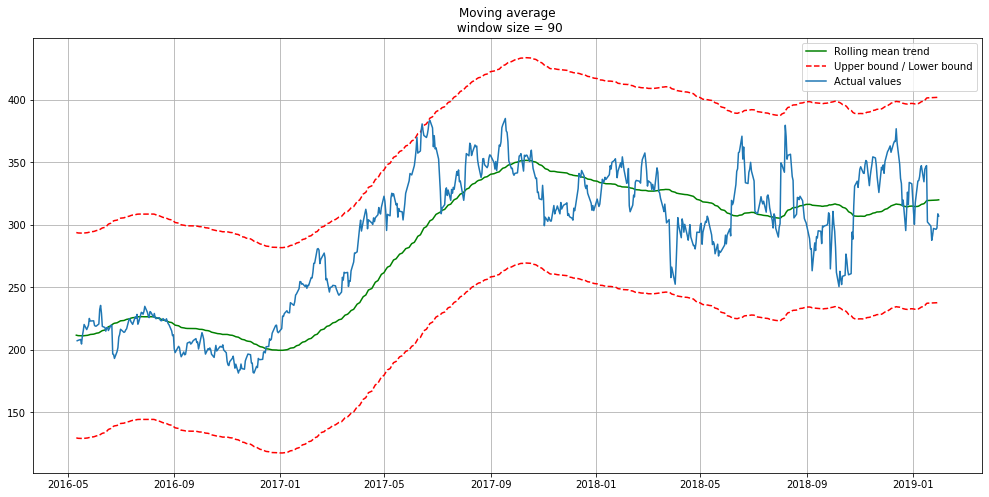

In [325]:

#Smooth by previous quarter (90 days)
plot_moving_average(tesla.Close, 90, plot_intervals=True)

# Exponential Model

Exponential smoothing uses a similar logic to moving average, but this time, a different decreasing weight is assigned to each observations. In other words, less importance is given to observations as we move further from the present (very old observations become less important).

Double exponential smoothing is used when there is a trend in the time series. In that case, we use this technique, which is simply a recursive use of exponential smoothing twice.

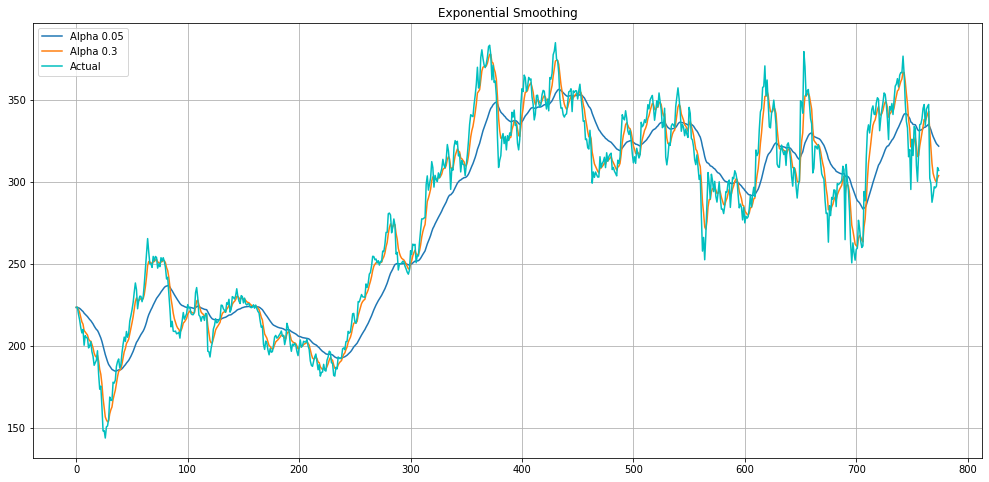

In [326]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(tesla.Close, [0.05, 0.3])

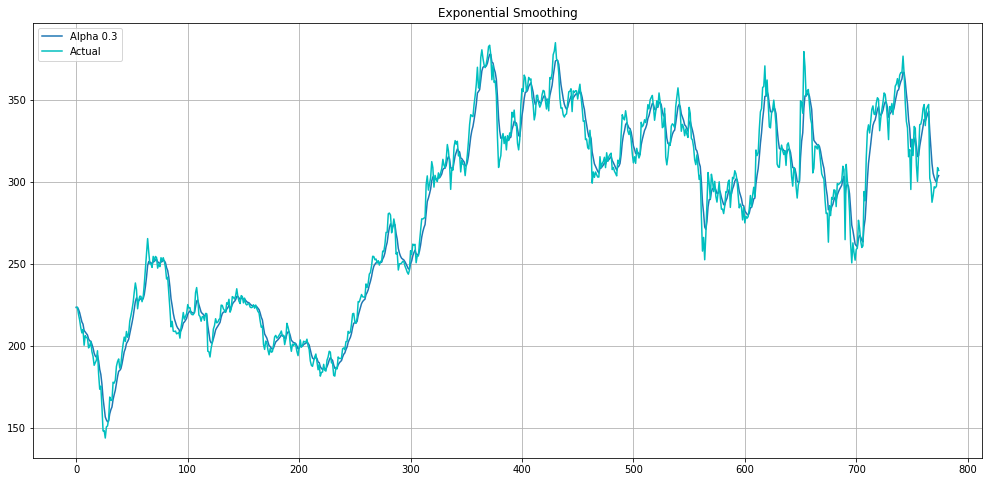

In [327]:
plot_exponential_smoothing(tesla.Close, [0.3])

# Modelling

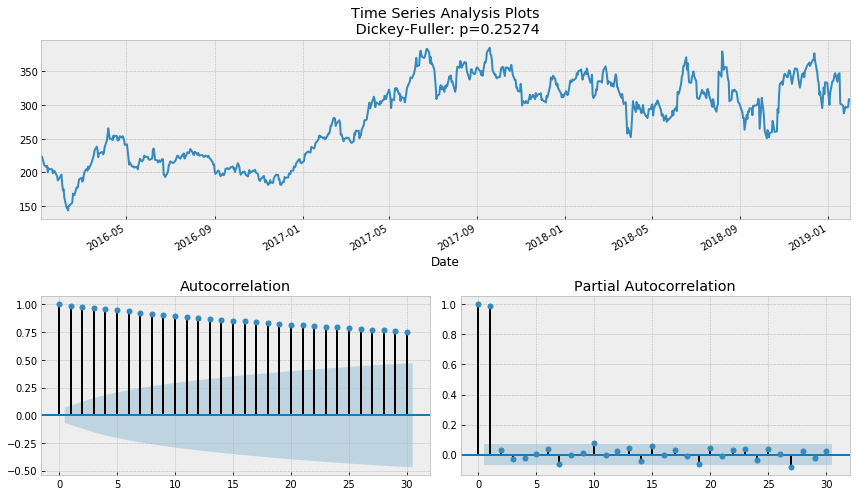

In [328]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(tesla.Close, lags=30)

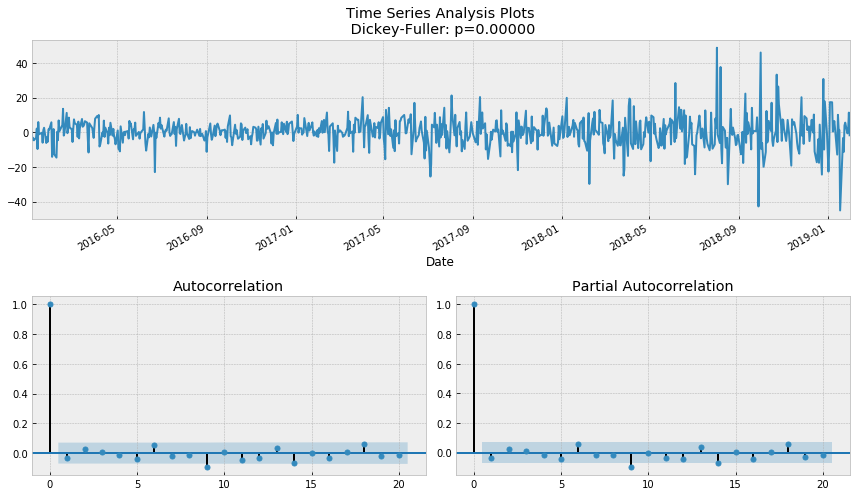

In [332]:
# Take the first difference to remove to make the process stationary
data_diff = tesla.Close - tesla.Close.shift(1)

tsplot(data_diff[1:], lags=20)

# Accuracy Predication using- Random Forest Model


In [333]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [334]:
tesla.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [335]:
 # Shift close down to predict next day
pd.concat([tesla.High, tesla.Close.shift(-5)], axis=1)

,High,Close
Date,,
2016-01-04,231.380005,207.850006
2016-01-05,226.889999,209.970001
2016-01-06,220.050003,200.309998
2016-01-07,218.440002,206.179993
2016-01-08,220.440002,204.990005
...,...,...
2019-01-25,298.519989,NaN
2019-01-28,297.459991,NaN
2019-01-29,298.559998,NaN


In [336]:
# Need to remove NA
# Regression - Try to predict Mean_Humidity (y) from non humidity columns (X)
# Get training set (X_train)
def valid(col):
     return 'Close' not in col
dummy = tesla.dropna()


# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
X = tesla[[x for x in tesla.columns if valid(x)]].iloc[:-5]

# for the dependent variable, we remove the NA, so that removes the last row, too
y = tesla.Close.shift(-5).dropna()

In [337]:
X.T

Date,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24
High,2.313800e+02,2.268900e+02,2.200500e+02,2.184400e+02,2.204400e+02,2.144500e+02,2.137400e+02,2.126500e+02,2.100000e+02,2.050700e+02,...,3.453900e+02,3.484100e+02,3.425000e+02,3.488000e+02,3.520000e+02,3.515000e+02,3.271300e+02,3.080000e+02,2.945000e+02,2.936800e+02
Low,2.190000e+02,2.200000e+02,2.159800e+02,2.136700e+02,2.107700e+02,2.030000e+02,2.053100e+02,2.000000e+02,1.933800e+02,1.972500e+02,...,3.317900e+02,3.387700e+02,3.340000e+02,3.345000e+02,3.435000e+02,3.441500e+02,2.997300e+02,2.955000e+02,2.816900e+02,2.792800e+02
Open,2.307200e+02,2.263600e+02,2.200000e+02,2.141900e+02,2.178600e+02,2.140100e+02,2.116000e+02,2.120100e+02,2.022100e+02,1.989700e+02,...,3.344000e+02,3.420900e+02,3.423800e+02,3.350000e+02,3.447800e+02,3.462100e+02,3.230000e+02,3.048200e+02,2.925000e+02,2.830300e+02
Volume,6.827100e+06,3.186800e+06,3.779100e+06,3.554300e+06,3.628100e+06,4.091400e+06,3.091900e+06,4.126400e+06,6.490700e+06,5.578600e+06,...,6.056400e+06,5.039100e+06,5.247300e+06,6.056600e+06,4.691700e+06,3.676700e+06,2.415080e+07,1.206670e+07,1.253000e+07,8.012200e+06


In [338]:
y

Date
2016-01-04    207.850006
2016-01-05    209.970001
2016-01-06    200.309998
2016-01-07    206.179993
2016-01-08    204.990005
                 ...    
2019-01-17    297.040009
2019-01-18    296.380005
2019-01-22    297.459991
2019-01-23    308.769989
2019-01-24    307.019989
Name: Close, Length: 770, dtype: float64

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [340]:
# Create a model 
rf_model = RandomForestRegressor()

In [341]:
# Train the model
rf_model.fit(X_train, y_train)

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [342]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.8884680239577355

In [343]:
# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [344]:
# Get R2 measure (indicator of accuracy 1 is perfect 0 is horrible)
rf_model.score(X_test, y_test)

0.8824883009979267

In [345]:
y_pred = rf_model.predict(X_test)

In [346]:
type(y_pred)

numpy.ndarray

In [347]:
y_pred[0:10]

array([316.34399414, 198.00600281, 200.80800018, 162.55299988,
       223.20700226, 197.32700043, 189.40599518, 327.3       ,
       325.86599731, 221.78999939])

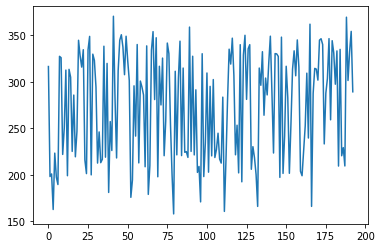

In [348]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

In [349]:
type(y_test)

pandas.core.series.Series

In [350]:
y_test2 = y_test.as_matrix()
type(y_test2)

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [351]:
y_test2[0:10]

array([349.54000854, 214.44000244, 215.1499939 , 187.42999268,
       211.41000366, 216.5       , 197.58000183, 302.51000977,
       318.95999146, 215.19999695])

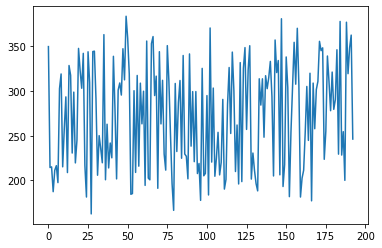

In [352]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

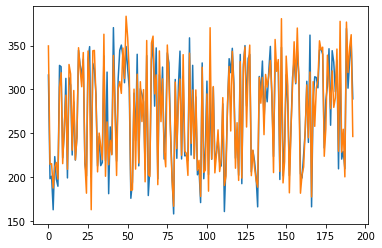

In [353]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

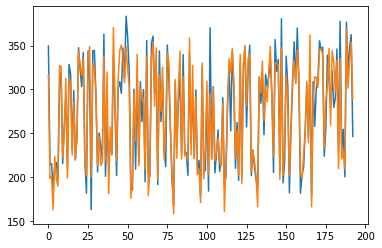

In [354]:
import matplotlib.pyplot as plt
plt.plot(y_test2)
plt.plot(y_pred)

In [355]:
type(y_test)

pandas.core.series.Series

In [356]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,Close
0,316.343994,349.540009
1,198.006003,214.440002
2,200.808000,215.149994
3,162.553000,187.429993
4,223.207002,211.410004
...,...,...
188,369.423999,376.790009
189,301.361996,319.269989
190,332.335999,348.049988
191,354.155997,362.369995


In [357]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('High', 0.7281496866016122),
 ('Low', 0.21839841485613548),
 ('Open', 0.028690128569958583),
 ('Volume', 0.024761769972293787)]

#####################################################################################################

# 2. Bit-Coin

In [358]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader as web
import datetime
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2019, 1, 30)
btc = web.DataReader('BTC-USD' , 'yahoo', start, end)
btc.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600,431.959991
2016-01-06,431.855988,426.341003,431.855988,429.105011,34042500,429.105011
2016-01-07,458.765991,429.076996,430.010986,458.048004,87562200,458.048004
2016-01-08,462.933990,447.937988,457.537994,453.230011,56993000,453.230011
2016-01-09,454.640015,446.889008,453.382996,447.610992,32278000,447.610992


In [359]:
btc.to_csv('btc.csv')

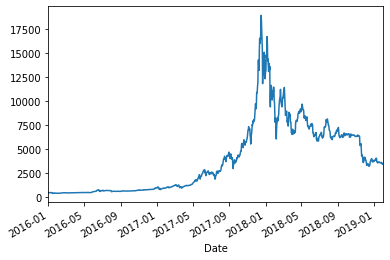

In [360]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = btc['Low']
vol.plot()

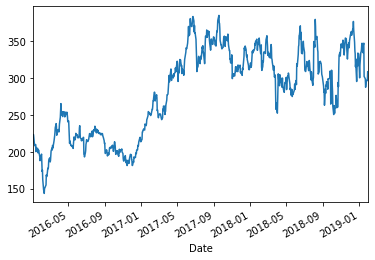

In [361]:
close = tesla['Close']
close.plot()

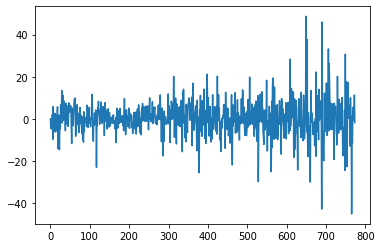

In [362]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

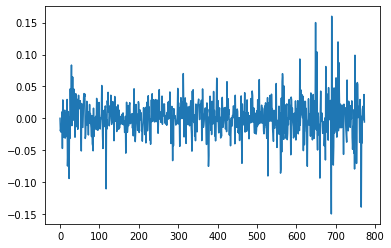

In [363]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [364]:
vol.corr(close)
# a value of 0.3 essentially means little correlation..

0.6045267365349285

# Modeling average

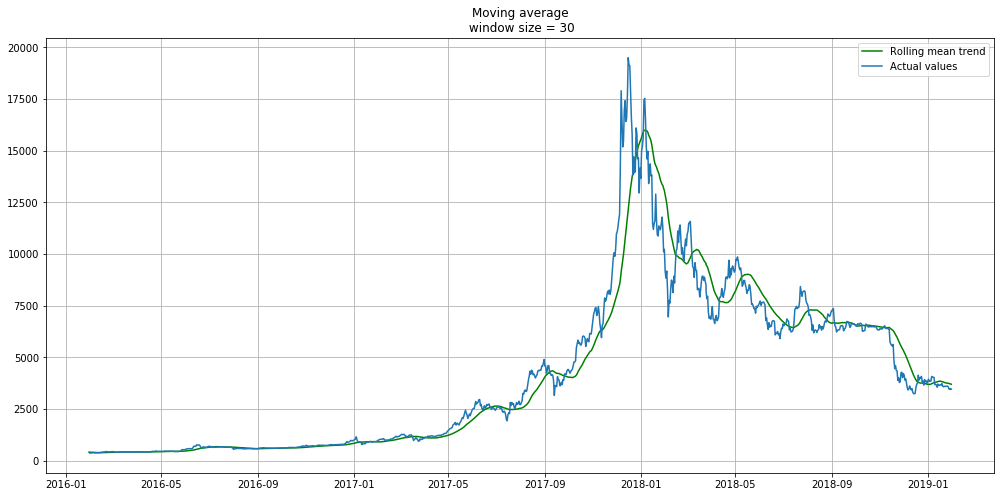

In [365]:
from sklearn.metrics import mean_absolute_error

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(btc.Close, 30)

#Smooth by the previous month (30 days)
#plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
#plot_moving_average(data.CLOSE, 90, plot_intervals=True)

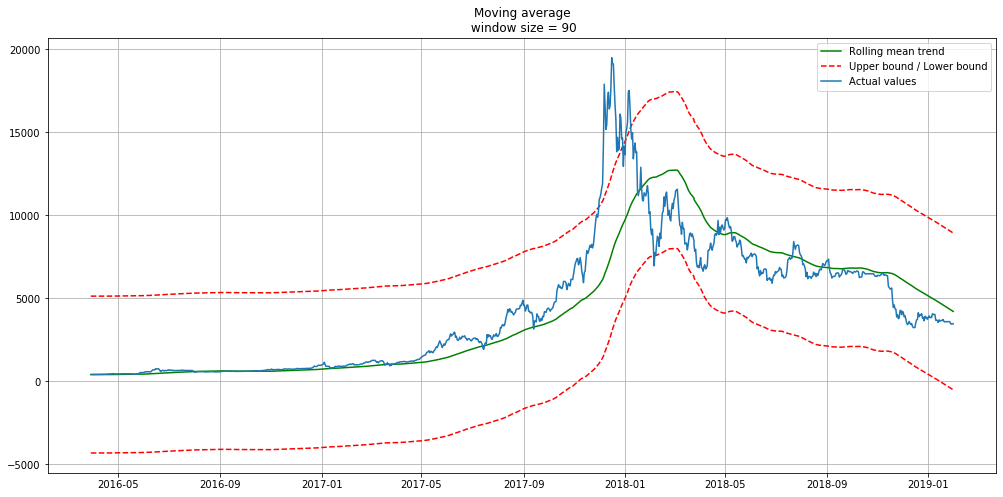

In [366]:
plot_moving_average(btc.Close, 90, plot_intervals=True)

# Exponential Smoothing

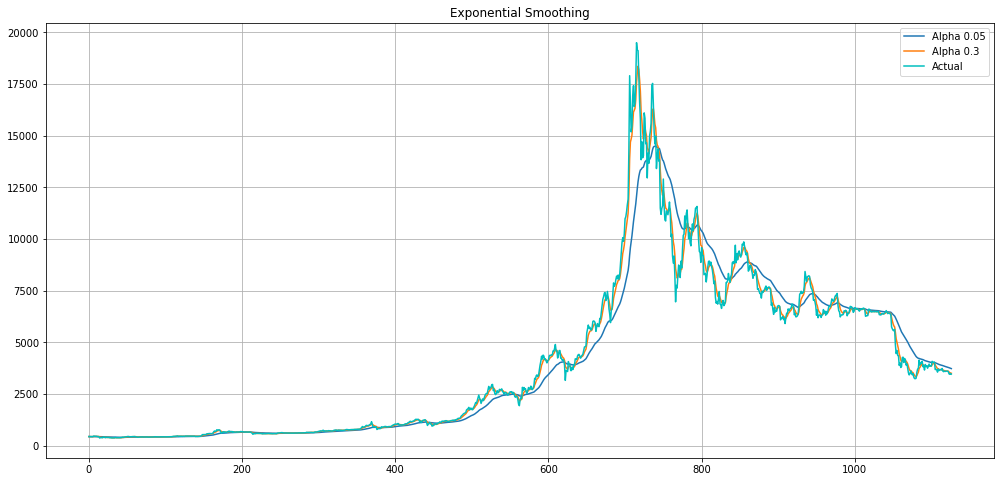

In [367]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(btc.Close, [0.05, 0.3])

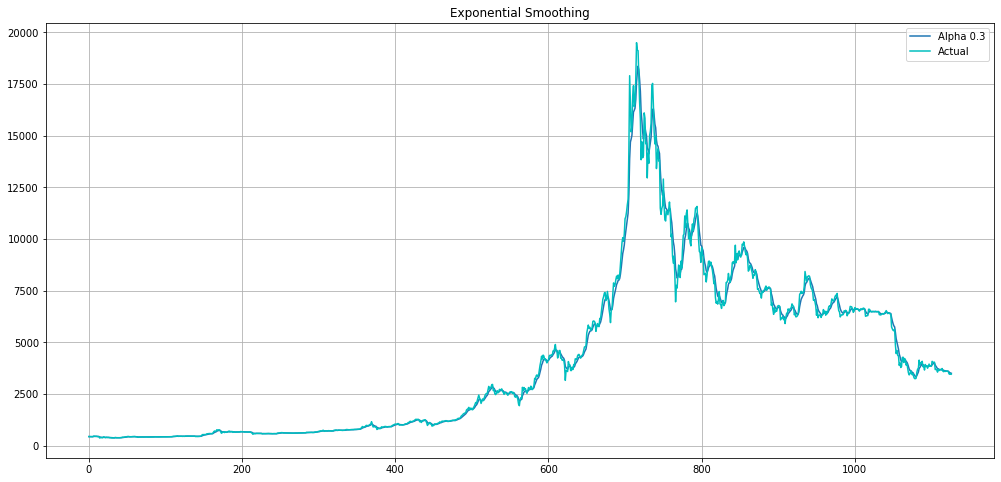

In [368]:
plot_exponential_smoothing(btc.Close, [ 0.3])

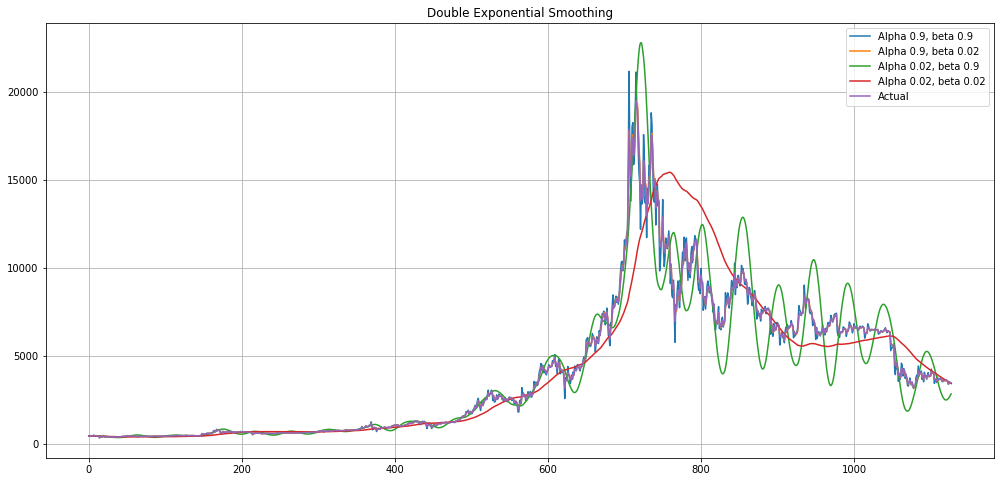

In [369]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(btc.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Modelling

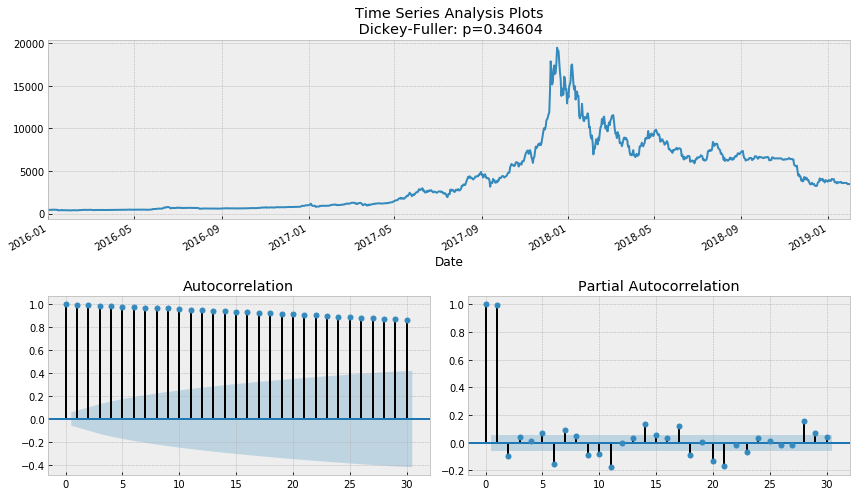

In [370]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(btc.Close, lags=30)

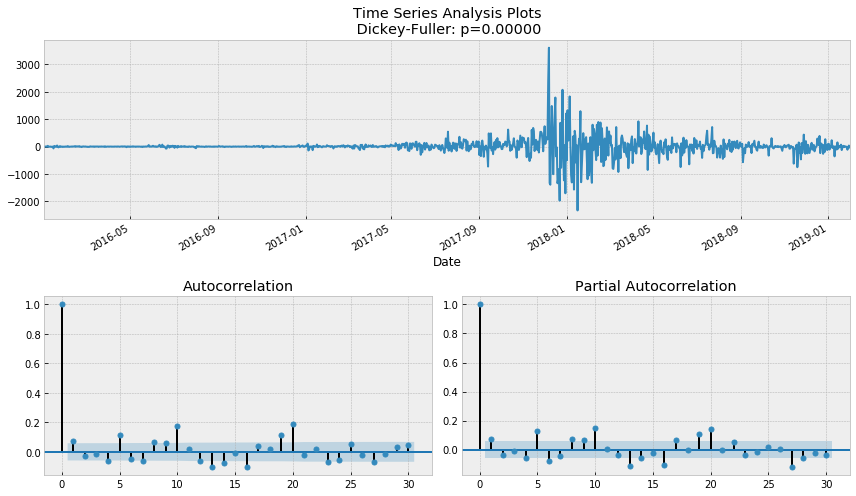

In [371]:
# Take the first difference to remove to make the process stationary
data_diff = btc.Close - btc.Close.shift(1)

tsplot(data_diff[1:], lags=30)

# RandomForestRegressor

In [372]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [373]:
btc.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [374]:
# Shift close down to predict next day
pd.concat([btc.High, btc.Close.shift(-10)], axis=1)

,High,Close
Date,,
2016-01-01,436.246002,448.428009
2016-01-02,436.062012,435.690002
2016-01-03,433.743011,432.371002
2016-01-04,434.516998,430.306000
2016-01-05,434.182007,364.330994
...,...,...
2019-01-27,3612.671387,NaN
2019-01-28,3586.750977,NaN
2019-01-29,3476.065430,NaN


In [375]:
# Need to remove NA
# Regression - Try to predict Mean_Humidity (y) from non humidity columns (X)
# Get training set (X_train)
def valid(col):
     return 'Close' not in col
dummy1 = btc.dropna()


# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
X = btc[[x for x in btc.columns if valid(x)]].iloc[:-10]

# for the dependent variable, we remove the NA, so that removes the last row, too
y = btc.Close.shift(-10).dropna()

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142)

In [377]:
# Create a model 
rf_model = RandomForestRegressor()

In [378]:
# Train the model
rf_model.fit(X_train, y_train)

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [379]:
# Get R2 measure (indicator of accuracy 1 is perfect 0 is horrible)
rf_model.score(X_test, y_test)

0.9481126970761192

In [380]:
y_pred = rf_model.predict(X_test)

In [381]:
type(y_pred)

numpy.ndarray

In [382]:
y_pred[0:10]

array([  782.29110107,  6876.32109375,  4473.50236816,   611.96131592,
        1205.4130127 ,  7165.89394531,  6739.49008789, 12681.42001953,
        1958.07596436,  3558.44702148])

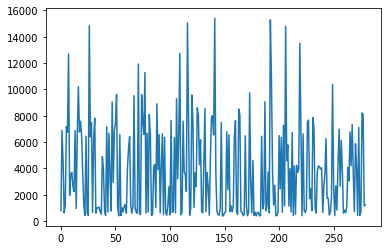

In [383]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

In [384]:
type(y_test)

pandas.core.series.Series

In [385]:
y_test2 = y_test.as_matrix()
type(y_test2)

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [386]:
y_test2[0:10]

array([  784.90698242,  7047.16015625,  4017.26855469,   616.75201416,
        1250.15002441,  9818.34960938,  7653.97998047, 19114.19921875,
        1888.65002441,  3424.58813477])

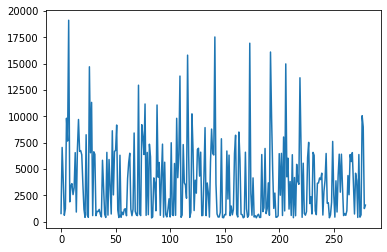

In [387]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

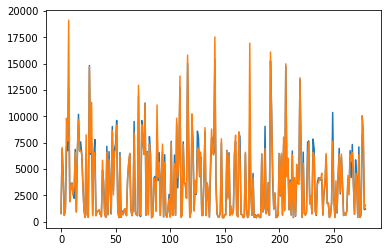

In [388]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

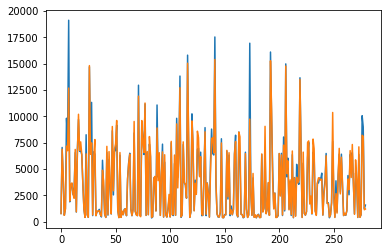

In [389]:
import matplotlib.pyplot as plt
plt.plot(y_test2)
plt.plot(y_pred)

In [390]:
type(y_test)

pandas.core.series.Series

In [391]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,Close
0,782.291101,784.906982
1,6876.321094,7047.160156
2,4473.502368,4017.268555
3,611.961316,616.752014
4,1205.413013,1250.150024
...,...,...
275,679.490686,655.275024
276,8201.565088,10058.799805
277,8098.767187,8987.049805
278,1138.842993,1251.010010


In [392]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('High', 0.7138118896659646),
 ('Low', 0.18824428026301582),
 ('Open', 0.06052688296855051),
 ('Volume', 0.03741694710246909)]

# 3. Reliance data :

In [393]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader as web
import datetime
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 3, 30)
reliance = web.DataReader('RELIANCE.NS' , 'yahoo', start, end)
reliance.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-01,1127.300049,1110.099976,1125.250000,1121.000000,4455850,1114.826294
2019-01-02,1127.000000,1101.000000,1114.500000,1106.400024,7144970,1100.306763
2019-01-03,1114.599976,1090.099976,1107.500000,1092.750000,7446457,1086.731934
2019-01-04,1104.449951,1081.099976,1097.400024,1098.650024,8465141,1092.599487
2019-01-07,1118.449951,1101.000000,1107.000000,1104.750000,5513559,1098.665771
2019-01-08,1109.949951,1096.000000,1105.099976,1104.650024,5625153,1098.566406
2019-01-09,1117.000000,1098.699951,1112.000000,1110.750000,5766805,1104.632812
2019-01-10,1111.000000,1103.000000,1107.750000,1107.500000,4080283,1101.400635
2019-01-11,1113.800049,1088.599976,1107.599976,1098.050049,6463903,1092.002808


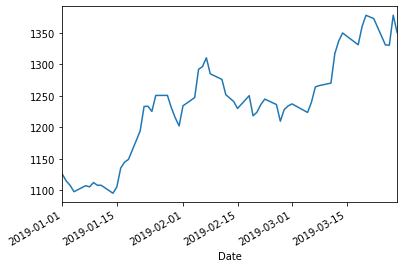

In [394]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = reliance['Open']
vol.plot()

In [395]:
reliance.to_csv('reliance.csv')

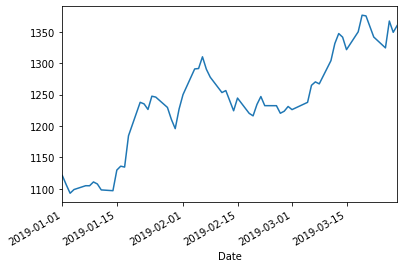

In [396]:
close = reliance['Close']
close.plot()

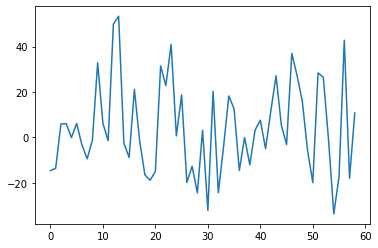

In [397]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

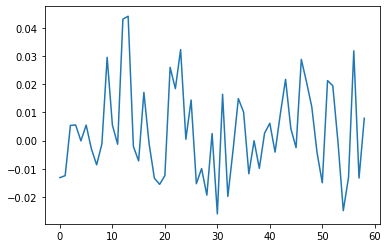

In [398]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [399]:
vol.corr(close)
# a value of 0.3 essentially means little correlation..

0.9760564669219882

# Moving average

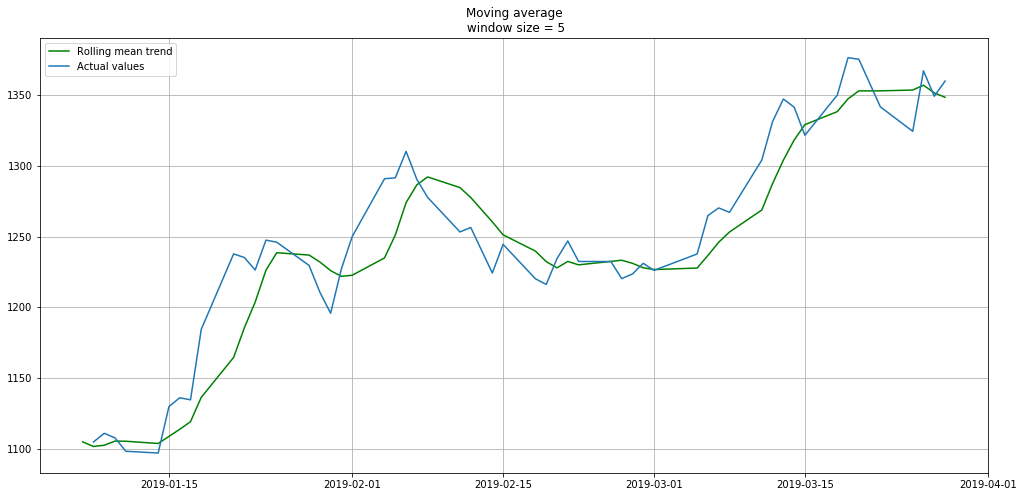

In [400]:
from sklearn.metrics import mean_absolute_error

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(reliance.Close, 5)

#Smooth by the previous month (30 days)
#plot_moving_average(reliance.CLOSE, 30)

#Smooth by previous quarter (90 days)
#plot_moving_average(reliance.CLOSE, 90, plot_intervals=True)

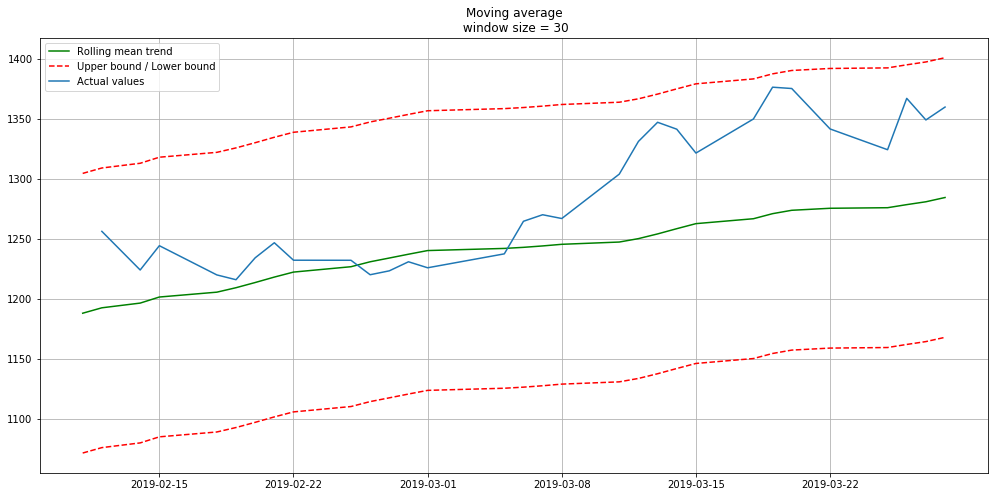

In [401]:
plot_moving_average(reliance.Close, 30, plot_intervals=True)

# Exponential Smoothing

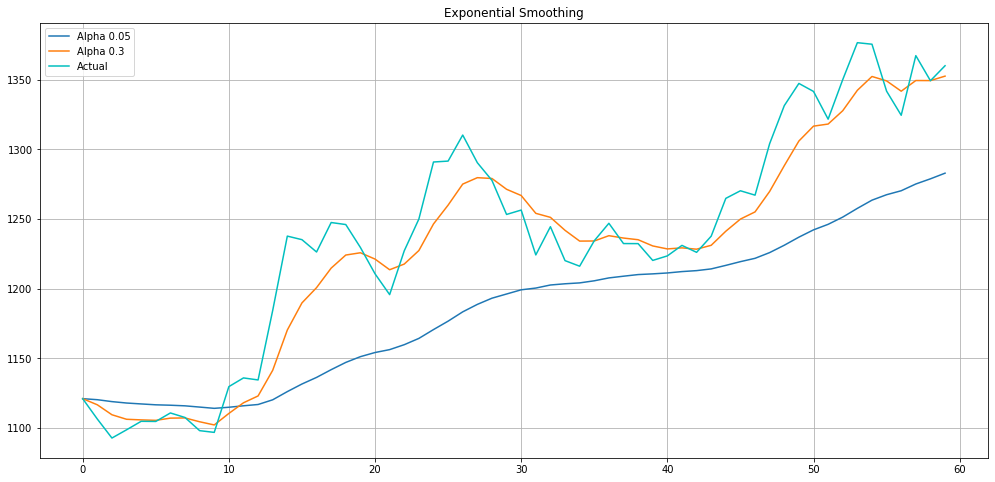

In [402]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(reliance.Close, [0.05, 0.3])

# Modelling

C:\Users\Abhishek\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


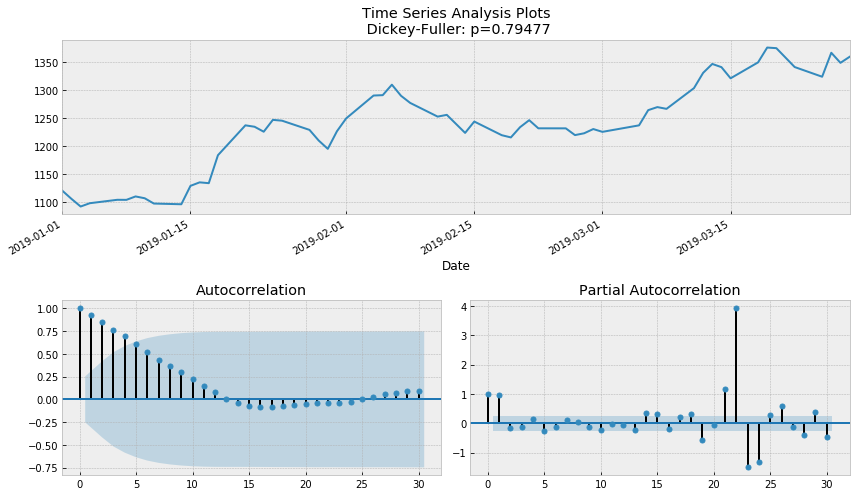

In [403]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(reliance.Close, lags=30)

C:\Users\Abhishek\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


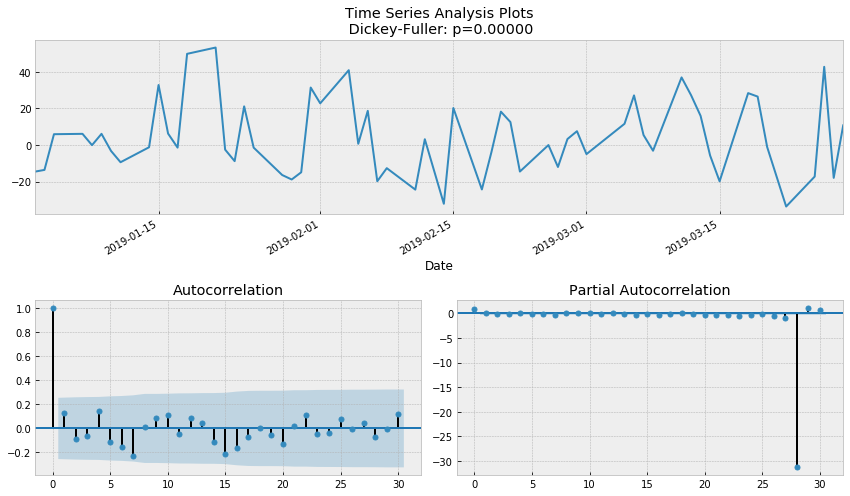

In [404]:
# Take the first difference to remove to make the process stationary
data_diff = reliance.Close - reliance.Close.shift(1)

tsplot(data_diff[1:], lags=30)

# Random Forest Model

In [405]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [406]:
# Shift close down to predict next day
pd.concat([reliance.High, reliance.Close.shift(-5)], axis=1)

,High,Close
Date,,
2019-01-01,1127.300049,1104.650024
2019-01-02,1127.000000,1110.750000
2019-01-03,1114.599976,1107.500000
2019-01-04,1104.449951,1098.050049
2019-01-07,1118.449951,1096.800049
2019-01-08,1109.949951,1129.650024
2019-01-09,1117.000000,1135.900024
2019-01-10,1111.000000,1134.449951
2019-01-11,1113.800049,1184.349976


In [407]:
# Need to remove NA
# Regression - Try to predict Mean_Humidity (y) from non humidity columns (X)
# Get training set (X_train)
def valid(col):
     return 'Close' not in col
dummy2 = reliance.dropna()


# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
X = reliance[[x for x in btc.columns if valid(x)]].iloc[:-2]

# for the dependent variable, we remove the NA, so that removes the last row, too
y = reliance.Close.shift(-2).dropna()

In [408]:
X.T

Date,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,...,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-18,2019-03-19,2019-03-20,2019-03-22,2019-03-25,2019-03-26
High,1.127300e+03,1127.0,1.114600e+03,1.104450e+03,1.118450e+03,1.109950e+03,1.117000e+03,1111.00,1.113800e+03,1.100500e+03,...,1.334000e+03,1.360000e+03,1.362000e+03,1.358800e+03,1.357950e+03,1.380000e+03,1.388000e+03,1.380900e+03,1.336850e+03,1.371600e+03
Low,1.110100e+03,1101.0,1.090100e+03,1.081100e+03,1.101000e+03,1.096000e+03,1.098700e+03,1103.00,1.088600e+03,1.086400e+03,...,1.314250e+03,1.328100e+03,1.336100e+03,1.311200e+03,1.329000e+03,1.343100e+03,1.364000e+03,1.336700e+03,1.316700e+03,1.330000e+03
Open,1.125250e+03,1114.5,1.107500e+03,1.097400e+03,1.107000e+03,1.105100e+03,1.112000e+03,1107.75,1.107600e+03,1.095000e+03,...,1.316900e+03,1.337000e+03,1.349750e+03,1.345000e+03,1.331000e+03,1.360000e+03,1.377800e+03,1.372500e+03,1.330600e+03,1.330300e+03
Volume,4.455850e+06,7144970.0,7.446457e+06,8.465141e+06,5.513559e+06,5.625153e+06,5.766805e+06,4080283.00,6.463903e+06,4.111782e+06,...,1.122874e+07,1.123605e+07,1.040205e+07,1.589309e+07,1.010523e+07,9.805318e+06,9.892823e+06,1.146511e+07,7.951992e+06,9.479288e+06


In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142)

In [410]:
# Create a model 
rf_model = RandomForestRegressor()

In [411]:
# Train the model
rf_model.fit(X_train, y_train)

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [412]:
# Get R2 measure (indicator of accuracy 1 is perfect 0 is horrible)
rf_model.score(X_test, y_test)

0.8790837319502288

In [413]:
y_pred = rf_model.predict(X_test)

In [414]:
type(y_pred)

numpy.ndarray

In [415]:
y_pred[0:10]

array([1240.83001709, 1255.15500488, 1302.65999756, 1340.69002686,
       1250.68001709, 1111.02000732, 1283.00499268, 1232.49499512,
       1339.72501221, 1236.74500732])

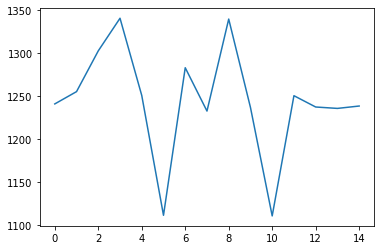

In [416]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

In [417]:
type(y_test)

pandas.core.series.Series

In [418]:
y_test2 = y_test.as_matrix()
type(y_test2)

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [419]:
y_test2[0:10]

array([1223.5       , 1226.30004883, 1347.30004883, 1376.55004883,
       1231.05004883, 1096.80004883, 1256.40002441, 1220.25      ,
       1367.25      , 1270.25      ])

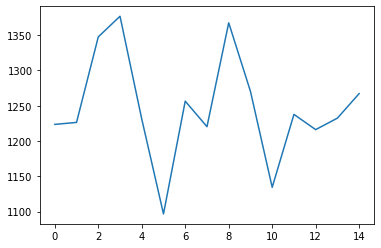

In [420]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

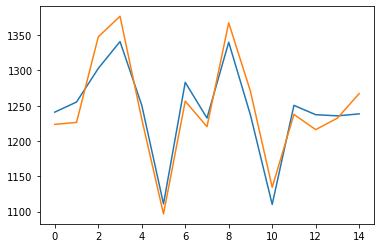

In [421]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

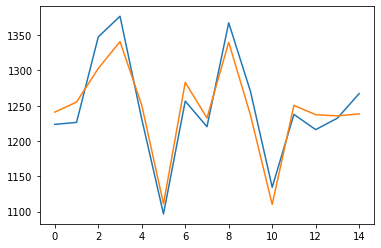

In [422]:
import matplotlib.pyplot as plt
plt.plot(y_test2)
plt.plot(y_pred)

In [423]:
type(y_test)

pandas.core.series.Series

In [424]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,Close
0,1240.830017,1223.500000
1,1255.155005,1226.300049
2,1302.659998,1347.300049
3,1340.690027,1376.550049
4,1250.680017,1231.050049
5,1111.020007,1096.800049
6,1283.004993,1256.400024
7,1232.494995,1220.250000
8,1339.725012,1367.250000
9,1236.745007,1270.250000


In [425]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('High', 0.44773786987647746),
 ('Open', 0.3440088337990985),
 ('Low', 0.19969077111047953),
 ('Volume', 0.008562525213944482)]